# Libreria 

In [1]:
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
#parsear XML
import csv   
from lxml import etree
#Parsear HTML
import requests
import urllib.request
from bs4 import BeautifulSoup
from urllib.request import urlopen
from bs4.builder import HTMLParserTreeBuilder
#para medir tiempo
from time import time 
import time

# Carga de Archivos XML

In [2]:
org = 'ptr'
ORGANISM = org
maxi ='01040'

pathways = requests.get('http://rest.kegg.jp/list/pathway/' + ORGANISM)  #lista de las vias metabolicas y otra informacion porpocionada por KEGG

for line in pathways.text.split('\n'):         # Se recorre la lista propocionada por  KEGG donde se estraen los nombres de las vias de KEGG
      pathwayid = line.split('\t')[0].replace('path:', '') 
      A = pathwayid+'.xml'                     # Le ponemos la extencion .xml para poder cargar los archivos
      if A == str(org)+str(maxi)+'.xml':           
            break
      locals()[str(pathwayid)] = etree.parse(A) # Guarda los  XML com el nombre de la via asignado por KEGG
      locals()[str(pathwayid)] = locals()[str(pathwayid)].getroot()  # Para transformar todos lo XML en directorios de python

## ARMANDO BASE DE DATOS CON PANDAS

##### crear archivo csv para guardar los datos. 

In [4]:
#data= pd.DataFrame(columns=('n', 'enzima', 'gen', 'nob_Keeg', 'path' ,'link')) # Crear tabla csv. 
#data.to_csv('data_'+org+'.csv', sep=';')                              

In [10]:
save=len(pd.read_csv('data_'+org+'.csv',index_col=0, delimiter=';')[['n']].values)
print(save)

2768


In [8]:
save=len(pd.read_csv('data_'+org+'.csv',index_col=0, delimiter=';')[['n']].values)

n=0

for line in pathways.text.split('\n'):
    
    pathwayid = line.split('\t')[0].replace('path:', '') 
    
    if pathwayid ==  str(org)+str(maxi):           
            break
    
    ii=locals()[str(pathwayid)]
    
    
    for i in range(0,len(ii)):
       
        if ii[i].tag=='entry':         
            A=ii[i].attrib            
            if A['type'] == 'gene':
                n=1+n
                
                if n > save:
                    
                    url = A['link']
                
                    response = requests.get(url)
                    soup = BeautifulSoup(response.text, "html.parser")
                    
                    gen    = soup.html.body.div.table.form.td.table.find_all('td')[3].find_all('div')[0].text.replace('\n', ' ').strip().split()[0].replace(',','')
                    
                    if gen == '(RefSeq)':
                        ll=6
                    else:
                        ll=7
                    
                    enzima = soup.html.body.div.table.form.td.table.find_all('td')[ll].text.strip()
                    
                    NewDat = [n , A['id'] , enzima, gen , A['name'].split( )[0] , pathwayid , A['link'] ]
                
                                
                    with open(r'data_'+org+'.csv', 'a' , newline='') as f:
                        writer = csv.writer(f,delimiter=';')
                        writer.writerow(NewDat)
                                              


In [9]:

n=0

for line in pathways.text.split('\n'):
    
    pathwayid = line.split('\t')[0].replace('path:', '') 
    
    if pathwayid == str(org)+str(maxi):           
            break
            
  
    ii=locals()[str(pathwayid)]
    
        
    
    for i in range(0,len(ii)):
       
        if ii[i].tag=='entry':         
            A=ii[i].attrib            
            if A['type'] == 'group':
                n=1+n 
                
                NewDat = [n , A['id'] , 'undefined_Enzima'+pathwayid , 'none' ,  A['name'] , pathwayid , 'no link']
                
                        
                with open(r'data_'+org+'.csv', 'a' , newline='') as f:
                    writer = csv.writer(f , delimiter=';')
                    writer.writerow(NewDat)            
           
                          

In [4]:
data=pd.read_csv('data_'+org+'.csv',index_col=0, sep=';')
data=data[['n' ,'enzima', 'nob_Keeg' ,'path']]
data=data.values
#data

In [5]:
for line in pathways.text.split('\n'):
    
    pathwayid = line.split('\t')[0].replace('path:', '') 
    
    if pathwayid == str(org)+str(maxi):           
            break
    
    locals()['NODES_'+str(pathwayid)]={}
    
    for i in data:
        if i[3] == pathwayid:
            locals()['NODES_'+str(pathwayid)][i[0]]= i[1] 
            #print(i[0],i[1], i[2], i[3])
    

In [6]:
#NODES_ptr00010

## PRIMERA RED

In [7]:
EDGES=[]

for line in pathways.text.split('\n'):        
    pathwayid = line.split('\t')[0].replace('path:', '') 
    
    if pathwayid == str(org)+str(maxi):           
            break
            
    ii=locals()[str(pathwayid)]
    
    NODES=locals()['NODES_'+str(pathwayid)]
   
    for i in range(0,len(ii)):
        if ii[i].tag=='relation':         
            A=ii[i].attrib            
            if A['type'] == 'ECrel':    #relación enzima-enzima, que indica dos enzimas que catalizan pasos de reacción sucesivos
                #print(A)
                EDGES.append( [  NODES[ A['entry1'] ] , NODES[ A['entry2'] ]  ]  ) 

#print(EDGES)                

In [8]:
G = nx.DiGraph() #--->DiGrafo para hacer un grado dirigido 
 
G.add_edges_from(EDGES)


#plt.figure(3,figsize=(50,50))
#nx.draw_kamada_kawai(G,font_size=15,node_size=1000,node_color='orange',with_labels=False)
#plt.savefig("net_"+org+".pdf")# Guardar la red en pdf. 
#plt.show()

In [9]:
g=nx.number_of_nodes(G)
print('g=',g)
L=nx.number_of_edges(G)
print('L=',L)

g= 811
L= 3059


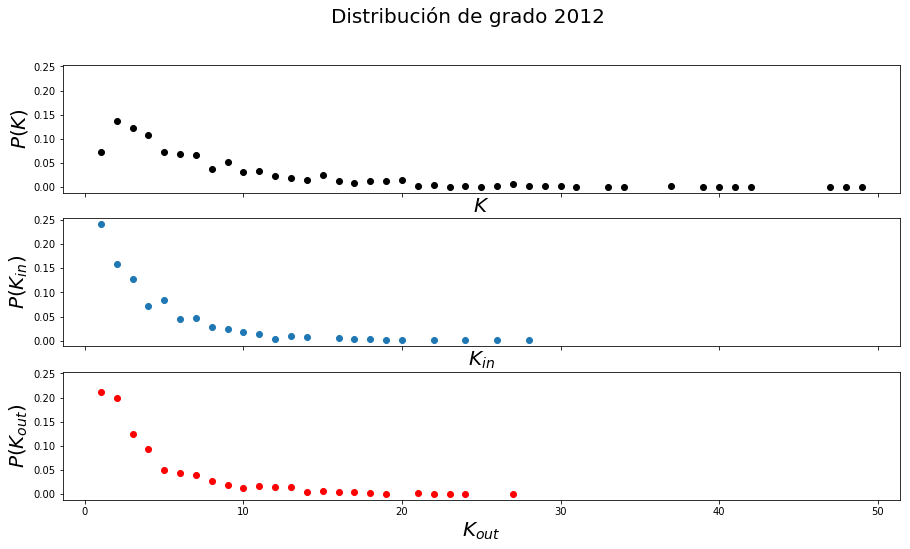

In [10]:
nodos=G.nodes

D=[] # un vector donde vamos a colocar el numero de vinvulos de todos los nodos
d=nx.degree(G) # Vector que contiene el par ordenado del nodo y su numero de vinculos
for i in nodos: 
    D.append(d[i])
    

D_in=[] # un vector donde vamos a colocar el numero de vinvulos de todos los nodos
d=G.in_degree(G) # Vector que contiene el par ordenado del nodo y su numero de vinculos
for i in nodos: 
    D_in.append(d[i])
    
    
D_out=[] # un vector donde vamos a colocar el numero de vinvulos de todos los nodos
d=G.out_degree(G) # Vector que contiene el par ordenado del nodo y su numero de vinculos
for i in nodos: 
    D_out.append(d[i])
    
    
P=[]
X=[]
for i in range(1,max(D)+1):
    if D.count(i) != 0: 
        P.append(D.count(i)/len(D))
        X.append(i)
        
P_in=[]
X_in=[]
for i in range(1,max(D_in)+1):
    if D_in.count(i) != 0: 
        P_in.append(D_in.count(i)/len(D_in))
        X_in.append(i)  

P_out=[]
X_out=[]
for i in range(1,max(D)+1):
    if D_out.count(i) != 0: 
        P_out.append(D_out.count(i)/len(D_out))
        X_out.append(i)
        
        
        
# GRAFICA DE LA PROVAVILIDAD VS EL NUMERO DE GRADO        
fig, axs = plt.subplots( 3 ,sharex = True, sharey = True, figsize=(15,8))

fig.suptitle('Distribución de grado 2012',fontsize=20)
axs[0].plot(X,P,'ko')         
axs[0].set_xlabel(r'$K$',fontsize=20)
axs[0].set_ylabel(r'$P(K)$',fontsize=20)

axs[1].plot(X_in,P_in,'o')         
axs[1].set_xlabel(r'$K_{in}$',fontsize=20)
axs[1].set_ylabel(r'$P(K_{in})$',fontsize=20)

axs[2].plot(X_out,P_out, 'ro')         
axs[2].set_xlabel(r'$K_{out}$',fontsize=20)
axs[2].set_ylabel(r'$P(K_{out})$',fontsize=20)

#plt.savefig("P_vs_k_2012.pdf")# Guardar la red en pdf.    

plt.show()

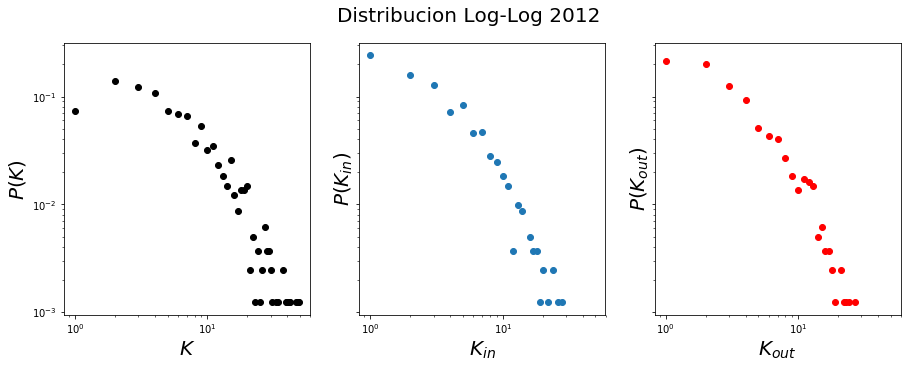

In [11]:

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3 ,sharex = True, sharey = True, figsize=(15,5))
fig.suptitle('Distribucion Log-Log 2012',fontsize=20)
ax1.plot(X,P,'ko')
ax1.set_xlabel(r'$K$',fontsize=20)
ax1.set_ylabel(r'$P(K)$',fontsize=20)

ax2.plot(X_in,P_in,'o')
ax2.set_xlabel(r'$K_{in}$',fontsize=20)
ax2.set_ylabel(r'$P(K_{in})$',fontsize=20)

ax3.plot(X_out,P_out,'ro')
ax3.set_xlabel(r'$K_{out}$',fontsize=20)
ax3.set_ylabel(r'$P(K_{out})$',fontsize=20)

# Escala log-log
plt.xscale('log') 
plt.yscale('log') 

#plt.savefig("Ley_de_potencias_2012.pdf")# Guardar la red en pdf.

plt.show()

In [12]:
d=G.degree(G) #Vector con el par ordenado de numero de aristas de entrada a cada uno de los nodos
d_in=G.in_degree(G)
d_out=G.out_degree(G)
degre=[]

for i in G.nodes:
    degre.append([i,d[i],d_in[i],d_out[i], d_in[i]-d_out[i] ])
df=pd.DataFrame(degre,columns=['Nombre', 'grado', 'grado_in', 'grado_out','dif_grado'])
df.sort_values(by='dif_grado', ascending=False)
#df.to_excel("df_2012.xlsx")

,Nombre,grado,grado_in,grado_out,dif_grado
54,glucuronosyltransferase [EC:2.4.1.17],40,28,12,16
665,galactoside 2-L-fucosyltransferase 1/2 [EC:2.4...,22,18,4,14
649,galactosylceramidase [EC:3.2.1.46],15,14,1,13
277,L-amino-acid oxidase [EC:1.4.3.2],29,20,9,11
590,phosphatidylethanolamine/phosphatidyl-N-methyl...,12,11,1,10
220,hypoxanthine phosphoribosyltransferase [EC:2.4...,24,17,7,10
230,nucleoside-triphosphatase [EC:3.6.1.15],12,11,1,10
309,D-amino-acid oxidase [EC:1.4.3.3],10,10,0,10
769,"all-trans-retinol 3,4-desaturase [EC:1.14.19.53]",9,9,0,9
591,cytosolic phospholipase A2 [EC:3.1.1.4],39,24,15,9


Text(0,0.5,'$f$')

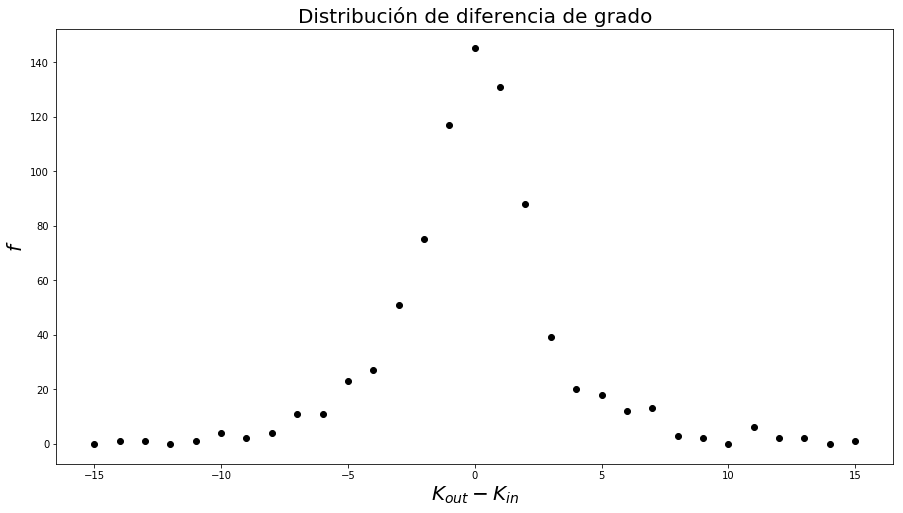

In [48]:
nodos=G.nodes

D=[] #
d_in=G.in_degree(G)
d_out=G.out_degree(G)
for i in nodos: 
    D.append(d_out(i)-d_in[i])
    
    
P=[]
X=[]
for i in range(min(D)+1,max(D)+1):
    P.append(D.count(i))
    X.append(i)

plt.figure(3,figsize=(15,8))
plt.title('Distribución de diferencia de grado',fontsize=20)
plt.plot(X,P,'ko')         
plt.xlabel(r'$K_{out}-K_{in}$',fontsize=20)
plt.ylabel(r'$f$',fontsize=20)

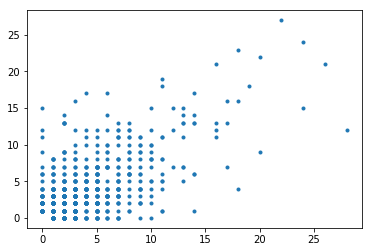

In [45]:
nodos=G.nodes

X=[]
Y=[]
d_in=G.in_degree(G)
d_out=G.out_degree(G)
for i in nodos: 
    X.append(d_in[i])
    Y.append(d_out(i))
    
plt.plot(X,Y,'.')    

In [13]:
intr=nx.betweenness_centrality(G) #dicionario en python
intr = pd.DataFrame([[key, intr[key]] for key in intr.keys()], columns=['Name', 'intermediacion'])
intr.sort_values(by='intermediacion', ascending=False)

,Name,intermediacion
54,glucuronosyltransferase [EC:2.4.1.17],0.086095
17,aldehyde dehydrogenase (NAD+) [EC:1.2.1.3],0.071790
59,aldehyde reductase [EC:1.1.1.21],0.066128
343,aldehyde oxidase [EC:1.2.3.1],0.063354
248,ectonucleotide pyrophosphatase/phosphodiestera...,0.059300
591,cytosolic phospholipase A2 [EC:3.1.1.4],0.053723
78,"beta-1,4-galactosyltransferase 1 [EC:2.4.1.22 ...",0.048615
5,phosphoglucomutase [EC:5.4.2.2],0.045428
363,monoamine oxidase [EC:1.4.3.4],0.044903
1,hexokinase [EC:2.7.1.1],0.042498
